In [1]:
!pip install efficientnet

# Library

In [2]:
import tensorflow as tf
from tensorflow import keras
import os
import pandas as pd
import cv2
import numpy as np
import keras
import pickle
import os
from keras.preprocessing.image import ImageDataGenerator
from sklearn.model_selection import train_test_split
import matplotlib.pyplot as plt
from keras.models import Sequential,load_model
from keras.layers import Dense, Dropout, Flatten
from keras.layers import Conv2D, MaxPool2D, Conv3D, BatchNormalization, Activation,MaxPooling2D
from PIL import Image
from sklearn.metrics import classification_report,confusion_matrix
from sklearn.utils import shuffle
from keras.utils import to_categorical
from keras.callbacks import EarlyStopping
from keras.callbacks import EarlyStopping, ReduceLROnPlateau
from keras.optimizers import RMSprop ,Adam
import efficientnet.keras as efn
from tensorflow.keras.applications import ResNet50,VGG19
import pandas as pd
import glob

Using TensorFlow backend.


In [3]:
data_dir = '/kaggle/input/brain-tumor-mri-dataset'
train_dir = '/kaggle/input/brain-tumor-mri-dataset/Training'
test_dir = '/kaggle/input/brain-tumor-mri-dataset/Testing'

print(os.listdir(train_dir))
CATEGORIES = ['meningioma_tumor', 'glioma_tumor', 'no_tumor', 'pituitary_tumor']

['pituitary', 'notumor', 'meningioma', 'glioma']


<BarContainer object of 4 artists>

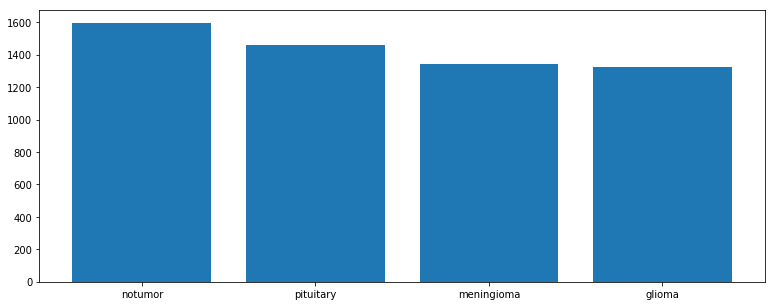

In [4]:
train_samples= glob.glob('/kaggle/input/brain-tumor-mri-dataset/Training/*/*.jpg')
train_samples = pd.Series(train_samples)
train_df = pd.DataFrame()
train_df['Filename'] = train_samples.map(lambda img_name: img_name.split("/")[-1])
train_df['ClassId'] = train_samples.map(lambda img_name: img_name.split("/")[-2])
class_id_distribution = train_df['ClassId'].value_counts()
plt.figure(figsize=(13,5))
plt.xticks(np.arange(43))
plt.bar(class_id_distribution.index, class_id_distribution.values)

In [5]:
for category in os.listdir(train_dir):
  print(category,len(os.listdir(os.path.join(train_dir,category))))

pituitary 1457
notumor 1595
meningioma 1339
glioma 1321


<BarContainer object of 4 artists>

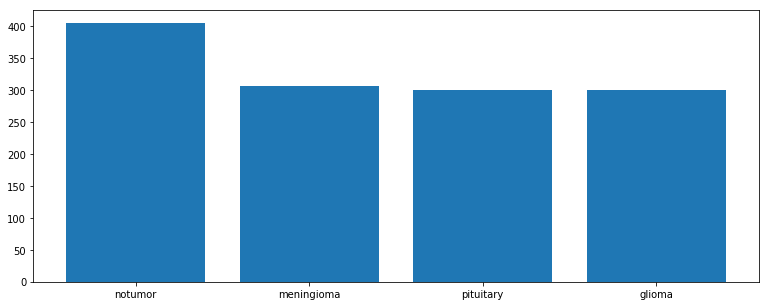

In [6]:
test_samples= glob.glob('/kaggle/input/brain-tumor-mri-dataset/Testing/*/*.jpg')
test_samples = pd.Series(test_samples)
test_df = pd.DataFrame()
test_df['Filename'] = test_samples.map(lambda img_name: img_name.split("/")[-1])
test_df['ClassId'] = test_samples.map(lambda img_name: img_name.split("/")[-2])
class_id_distribution = test_df['ClassId'].value_counts()
plt.figure(figsize=(13,5))
plt.xticks(np.arange(43))
plt.bar(class_id_distribution.index, class_id_distribution.values)

In [7]:
for category in os.listdir(train_dir):
  print(category,len(os.listdir(os.path.join(test_dir,category))))

pituitary 300
notumor 405
meningioma 306
glioma 300


In [9]:
train_img = []
train_lables = []
for i,path in enumerate(os.listdir(train_dir)):
  sub_path=train_dir+"/"+path
  for img in os.listdir(os.path.join(train_dir,path)):
    image_path=sub_path+"/"+img
    img_arr = cv2.imread(image_path)
    img_arr=cv2.resize(img_arr,(150,150))
    train_img.append(img_arr)
    train_lables.append(i)

In [10]:
test_img = []
test_lables = []
for i,path in enumerate(os.listdir(test_dir)):
  sub_path=test_dir+"/"+path
  for img in os.listdir(os.path.join(test_dir,path)):
    image_path=sub_path+"/"+img
    img_arr = cv2.imread(image_path)
    img_arr=cv2.resize(img_arr,(150,150))
    test_img.append(img_arr)
    test_lables.append(i)

# Preprocessing

In [11]:
train_img = np.array(train_img)
train_img = train_img/255.0
#train_img = train_img.reshape(-1,150,150,1)
train_y = np.array(train_lables)
test_img = np.array(test_img)
test_img = test_img/255.0
#test_img = test_img.reshape(-1,150,150,1)
test_y = np.array(test_lables)

In [12]:
print(train_img.shape)

(5712, 150, 150, 3)


In [13]:
count = 0
for i in train_lables:
  if i == 1:
    count += 1
count

1595

In [14]:
print(train_y.shape,test_y.shape)

(5712,) (1311,)


In [15]:
categories_list = {}
for i in train_lables:
  categories_list[i] = categories_list.get(i,0) + 1

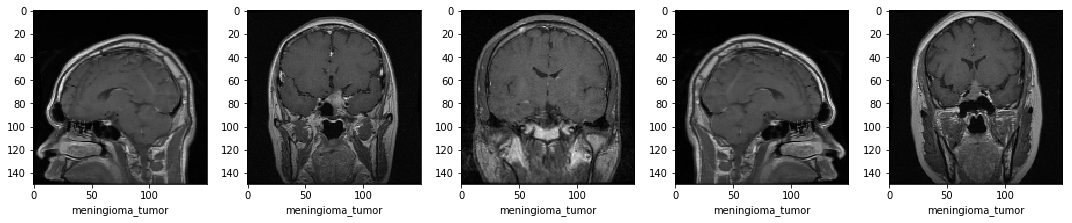

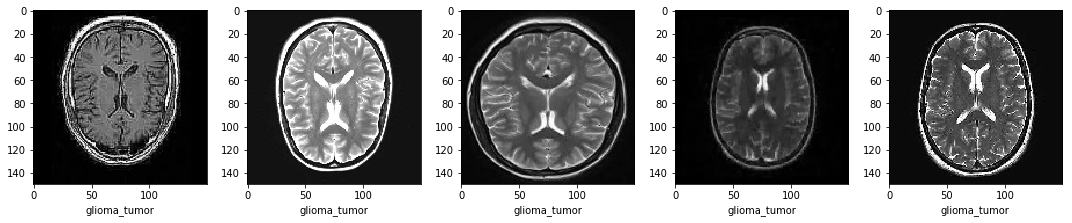

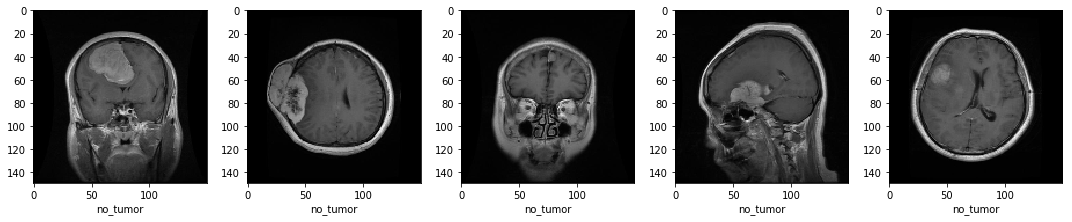

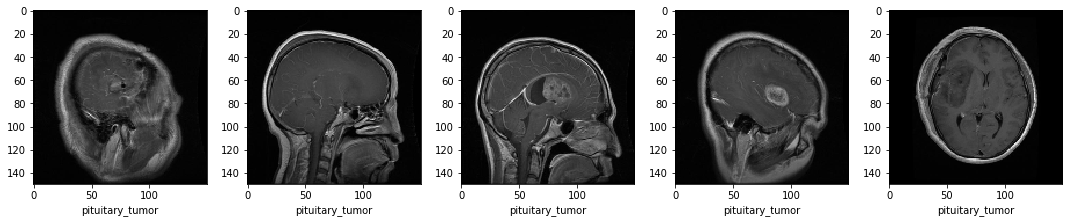

In [16]:
l = 0
for category in range(4):
  plt.figure(figsize = (15,15));
  count = 0
  for i in range(l,len(train_img)):
    if count<5:
        plt.subplot(1,5,count+1)
        plt.imshow(train_img[i]);
        plt.xlabel(CATEGORIES[category]);
        plt.tight_layout()
    else:
      break
    count += 1
  l = l + categories_list[category]

In [17]:
train_X,train_y = shuffle(train_img,train_y,random_state = 50)
train_X,val_X,train_y,val_y = train_test_split(train_X,train_y,test_size = 0.1)

In [18]:
train_y_encoded = to_categorical(train_y)
test_y_encoded = to_categorical(test_y)

print(train_X.shape)
print(train_y_encoded.shape)
print(test_img.shape)
print(test_y_encoded.shape)

(5140, 150, 150, 3)
(5140, 4)
(1311, 150, 150, 3)
(1311, 4)


# Basic CNN Model

In [16]:
def create_model():
    model = Sequential()

    model.add(Conv2D(32, (5, 5), input_shape=(150,150,3)))
    model.add(Activation('relu'))
    model.add(Conv2D(32, (4, 4)))  
    model.add(Activation('relu'))           
    model.add(MaxPool2D(pool_size=(3, 3)))  

    model.add(Conv2D(25, (3, 3),input_shape = (100,100,3)))  
    model.add(Activation('relu'))
    model.add(Conv2D(25, (2, 2),input_shape = (50,50,3)))  
    model.add(Activation('relu'))
    model.add(MaxPool2D(pool_size=(3, 3)))

    model.add(Flatten())
    model.add(Dense(250))
    model.add(Activation('relu'))

    model.add(Dense(4))
    model.add(Activation('softmax'))

    model.compile(loss = "categorical_crossentropy", optimizer='adam',metrics = ['accuracy'])
    print(model.summary())
    return model

In [ ]:
if os.path.isfile('/kaggle/input/pickle/history_CNN.pckl'):
    f = open('/kaggle/input/pickle/history_CNN.pckl', 'rb')
    hist = pickle.load(f)
    model = load_model("/kaggle/input/model-list/model.h5")
    
else:
    model = create_model()
    earlystop = EarlyStopping(monitor='val_loss', patience=3)
    hist = model.fit(train_X,train_y_encoded,epochs=19,validation_data = (val_X,to_categorical(val_y)),batch_size = 32,callbacks = [earlystop])
    model.save("model.h5")
    f = open('history_CNN.pckl', 'wb')
    pickle.dump(hist.history, f)
    hist = hist.history
f.close()

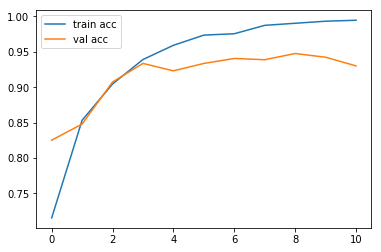

In [18]:
plt.plot(hist['accuracy'], label='train acc')
plt.plot(hist['val_accuracy'], label='val acc')
plt.legend()
plt.show()

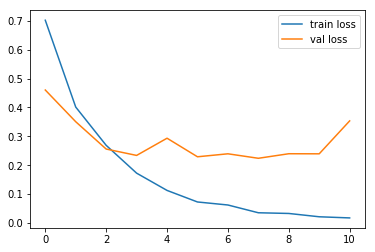

In [19]:
plt.plot(hist['loss'], label='train loss')
plt.plot(hist['val_loss'], label='val loss')
plt.legend()
plt.show()

In [20]:
pred = model.predict(test_img)
pred = np.argmax(pred,axis=1)
print(pred)
print(test_y)

[0 0 0 ... 3 3 3]
[0 0 0 ... 3 3 3]


In [21]:
print(classification_report(test_y,pred))

              precision    recall  f1-score   support

           0       0.96      0.91      0.94       300
           1       0.92      0.99      0.96       405
           2       0.88      0.78      0.83       306
           3       0.91      0.96      0.93       300

    accuracy                           0.92      1311
   macro avg       0.92      0.91      0.91      1311
weighted avg       0.92      0.92      0.92      1311



# CNN with Augmentation 

In [22]:
def create_model2():
    model2 = Sequential()

    model2.add(Conv2D(32, (5, 5), input_shape=(150,150,3)))
    model2.add(Activation('relu'))
    model2.add(Conv2D(32, (4, 4)))  
    model2.add(Activation('relu'))           
    model2.add(MaxPool2D(pool_size=(3, 3)))  

    model2.add(Conv2D(25, (3, 3),input_shape = (100,100,3)))  
    model2.add(Activation('relu'))
    model2.add(Conv2D(25, (2, 2),input_shape = (50,50,3)))  
    model2.add(Activation('relu'))
    model2.add(MaxPool2D(pool_size=(3, 3)))

    model2.add(Flatten())
    model2.add(Dense(250))
    model2.add(Activation('relu'))

    model2.add(Dense(4))
    model2.add(Activation('softmax'))

    model2.compile(loss = "categorical_crossentropy", optimizer='adam',metrics = ['accuracy'])
    print(model2.summary())
    return model2

In [23]:
datagen = ImageDataGenerator(
        featurewise_center = False,
        samplewise_center = False,
        featurewise_std_normalization=False,
        samplewise_std_normalization=False,
        zca_whitening=False,
        rotation_range=40, 
        width_shift_range=0.2,
        height_shift_range=0.2,  
        zoom_range=0.2,
        vertical_flip=False,
        horizontal_flip=True,
        fill_mode='nearest')

datagen.fit(train_X)
datagen.fit(test_img)

In [24]:
if os.path.isfile('/kaggle/input/pickle-files/history_CNN_aug.pckl'):
    f = open('/kaggle/input/pickle-files/history_CNN.pckl', 'rb')
    hist2 = pickle.load(f)
    model2 = load_model("/kaggle/input/model-list/model_aug.h5")
    model2.summary()
else:
    model2 = create_model2()
    earlystop = EarlyStopping(monitor='val_loss', patience=10,restore_best_weights=True)

    learning_rate_reduction = ReduceLROnPlateau(monitor='val_accuracy', 
                                                patience=5, 
                                                verbose=1, 
                                                factor=0.5, 
                                                min_lr=0.00001)

    callbacks = [earlystop, learning_rate_reduction]
    hist2 = model2.fit_generator(datagen.flow(train_X,train_y_encoded,batch_size = 32),epochs = 50,validation_data = (val_X,to_categorical(val_y)),callbacks = callbacks)
    model2.save("model_aug.h5")
    f = open('history_CNN_aug.pckl', 'wb')
    pickle.dump(hist2.history, f)    
    hist2 = hist2.history
f.close()

Model: "sequential_2"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv2d_5 (Conv2D)            (None, 146, 146, 32)      2432      
_________________________________________________________________
activation_7 (Activation)    (None, 146, 146, 32)      0         
_________________________________________________________________
conv2d_6 (Conv2D)            (None, 143, 143, 32)      16416     
_________________________________________________________________
activation_8 (Activation)    (None, 143, 143, 32)      0         
_________________________________________________________________
max_pooling2d_3 (MaxPooling2 (None, 47, 47, 32)        0         
_________________________________________________________________
conv2d_7 (Conv2D)            (None, 45, 45, 25)        7225      
_________________________________________________________________
activation_9 (Activation)    (None, 45, 45, 25)       

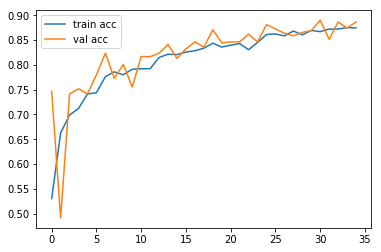

In [25]:
plt.plot(hist2['accuracy'], label='train acc')
plt.plot(hist2['val_accuracy'], label='val acc')
plt.legend()
plt.show()

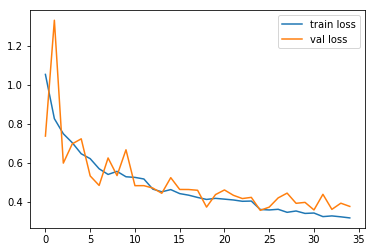

In [26]:
plt.plot(hist2['loss'], label='train loss')
plt.plot(hist2['val_loss'], label='val loss')
plt.legend()
plt.show()

In [27]:
pred = model2.predict(test_img)
pred = np.argmax(pred,axis=1)
print(pred)
print(test_y)

[0 0 0 ... 3 3 0]
[0 0 0 ... 3 3 3]


In [28]:
print(classification_report(test_y,pred))

              precision    recall  f1-score   support

           0       0.89      0.93      0.91       300
           1       0.83      0.99      0.90       405
           2       0.67      0.63      0.65       306
           3       0.89      0.69      0.77       300

    accuracy                           0.82      1311
   macro avg       0.82      0.81      0.81      1311
weighted avg       0.82      0.82      0.82      1311



# EfficientNetB1

In [19]:
def create_model3():
    effnet1 = efn.EfficientNetB1(weights = 'imagenet',include_top = False,input_shape = (150,150,3))
    model3 = effnet1.output
    model3 = keras.layers.GlobalAveragePooling2D()(model3)
    model3 = keras.layers.Dropout(rate=0.5)(model3)
    model3 = keras.layers.Dense(4,activation='softmax')(model3)
    model3 = keras.models.Model(inputs=effnet1.input, outputs = model3)

    optimizer = Adam(learning_rate = 0.000015)
    model3.compile(optimizer = optimizer, loss = "categorical_crossentropy",metrics = ['accuracy'])
    return model3

In [20]:
if os.path.isfile('./Pickle_file/history_CNN_effnet1.pckl'):
    f = open('./Pickle_file/history_CNN_effnet1.pckl', 'rb')
    hist3 = pickle.load(f)
    model3 = load_model("./Model_list/model_effnet1.h5")
    model3.summary()
else:
    model3 = create_model3()
    earlystop = EarlyStopping(monitor='val_loss', patience=5,restore_best_weights=True)
    hist3 = model3.fit(train_X,train_y_encoded,epochs=15,validation_data = (val_X,to_categorical(val_y)),batch_size = 32,callbacks = [earlystop])
    model3.save("model_effnet1.h5")
    f = open('history_CNN_effnet1.pckl', 'wb')
    pickle.dump(hist3.history, f)
    hist3 = hist3.history
f.close()

Model: "model_1"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_1 (InputLayer)            (None, 150, 150, 3)  0                                            
__________________________________________________________________________________________________
stem_conv (Conv2D)              (None, 75, 75, 32)   864         input_1[0][0]                    
__________________________________________________________________________________________________
stem_bn (BatchNormalization)    (None, 75, 75, 32)   128         stem_conv[0][0]                  
__________________________________________________________________________________________________
stem_activation (Activation)    (None, 75, 75, 32)   0           stem_bn[0][0]                    
____________________________________________________________________________________________

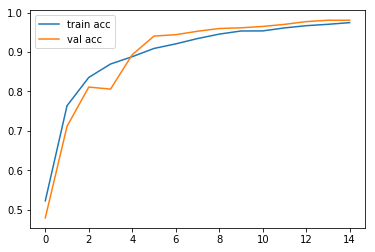

In [21]:
plt.plot(hist3['accuracy'], label='train acc')
plt.plot(hist3['val_accuracy'], label='val acc')
plt.legend()
plt.show()

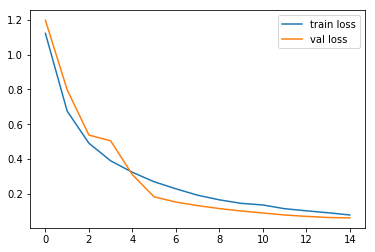

In [22]:
plt.plot(hist3['loss'], label='train loss')
plt.plot(hist3['val_loss'], label='val loss')
plt.legend()
plt.show()

In [23]:
pred = model3.predict(test_img)
pred = np.argmax(pred,axis=1)
print(pred)
print(test_y)

[0 0 0 ... 3 3 3]
[0 0 0 ... 3 3 3]


In [24]:
print(classification_report(test_y,pred))

              precision    recall  f1-score   support

           0       0.98      0.99      0.98       300
           1       1.00      1.00      1.00       405
           2       0.94      0.95      0.95       306
           3       0.98      0.95      0.96       300

    accuracy                           0.98      1311
   macro avg       0.97      0.97      0.97      1311
weighted avg       0.98      0.98      0.98      1311



# VGG19

In [25]:
def create_model4():
    vgg = VGG19(weights = 'imagenet',input_shape = (150,150,3),include_top= False)
    model4 = vgg.output
    model4 = tf.keras.layers.GlobalAveragePooling2D()(model4)
    model4 = tf.keras.layers.Dropout(rate=0.5)(model4)
    model4 = tf.keras.layers.Dense(4,activation='softmax')(model4)
    model4 = tf.keras.models.Model(inputs=vgg.input, outputs = model4)

    optimizer = tf.keras.optimizers.Adam(learning_rate = 0.000015)
    model4.compile(optimizer = optimizer, loss = "sparse_categorical_crossentropy",metrics = ['accuracy'])
    return model4

In [26]:
from tensorflow.keras.models import load_model

In [27]:
if os.path.isfile('./Pickle_file/history_CNN_vgg19.pckl'):
    f = open('./Pickle_file/history_CNN_vgg19.pckl', 'rb')
    hist4 = pickle.load(f)
    model4 = load_model("./Model_list/model_vgg19.h5")
    model4.summary()
else:
    model4 = create_model4()
    earlystop = EarlyStopping(monitor='val_loss', patience=5,restore_best_weights=True)
    hist4 = model4.fit(train_X,train_y,epochs=15,validation_data = (val_X,val_y),batch_size = 32,callbacks = [earlystop])
    model4.save("model_vgg19.h5")
    f = open('history_CNN_vgg19.pckl', 'wb')
    pickle.dump(hist4.history, f)    
f.close()

Model: "model"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_2 (InputLayer)         [(None, 150, 150, 3)]     0         
_________________________________________________________________
block1_conv1 (Conv2D)        (None, 150, 150, 64)      1792      
_________________________________________________________________
block1_conv2 (Conv2D)        (None, 150, 150, 64)      36928     
_________________________________________________________________
block1_pool (MaxPooling2D)   (None, 75, 75, 64)        0         
_________________________________________________________________
block2_conv1 (Conv2D)        (None, 75, 75, 128)       73856     
_________________________________________________________________
block2_conv2 (Conv2D)        (None, 75, 75, 128)       147584    
_________________________________________________________________
block2_pool (MaxPooling2D)   (None, 37, 37, 128)       0     

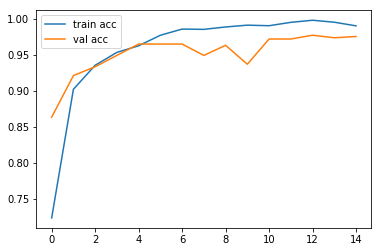

In [28]:
plt.plot(hist4['accuracy'], label='train acc')
plt.plot(hist4['val_accuracy'], label='val acc')
plt.legend()
plt.show()

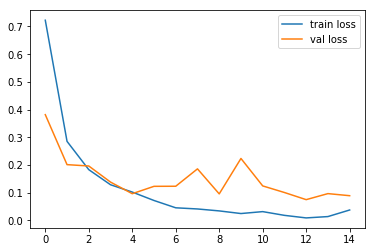

In [29]:
plt.plot(hist4['loss'], label='train loss')
plt.plot(hist4['val_loss'], label='val loss')
plt.legend()
plt.show()

In [30]:
pred = model4.predict(test_img)
pred = np.argmax(pred,axis=1)
print(pred)
print(test_y)

[0 0 0 ... 3 3 3]
[0 0 0 ... 3 3 3]


In [31]:
print(classification_report(test_y,pred))

              precision    recall  f1-score   support

           0       0.98      0.99      0.99       300
           1       1.00      1.00      1.00       405
           2       0.96      0.98      0.97       306
           3       0.99      0.98      0.98       300

    accuracy                           0.99      1311
   macro avg       0.99      0.99      0.99      1311
weighted avg       0.99      0.99      0.99      1311



# ResNet50

In [32]:
def create_model5():
    resnet = ResNet50(weights = 'imagenet',include_top = False,input_shape = (150,150,3))
    model5 = resnet.output
    model5 = tf.keras.layers.GlobalAveragePooling2D()(model5)
    model5 = tf.keras.layers.Dropout(rate=0.5)(model5)
    model5 = tf.keras.layers.Dense(4,activation='softmax')(model5)
    model5 = tf.keras.models.Model(inputs=resnet.input, outputs = model5)

    optimizer = tf.keras.optimizers.Adam(learning_rate = 0.000015)
    model5.compile(optimizer = optimizer, loss = "sparse_categorical_crossentropy",metrics = ['accuracy'])
    return model5

In [33]:
if os.path.isfile('./Pickle_file/history_CNN_resnet.pckl'):
    f = open('./Pickle_file/history_CNN_resnet.pckl', 'rb')
    hist5 = pickle.load(f)
    model5 = load_model("./Model_list/model_resnet.h5")
    model5.summary()
else:
    model5 = create_model5()
    earlystop = EarlyStopping(monitor='val_loss', patience=5,restore_best_weights=True)
    hist5 = model5.fit(train_X,train_y,epochs=15,validation_data = (val_X,val_y),batch_size = 32,callbacks = [earlystop])
    model5.save("model_resnet.h5")
    f = open('history_CNN_resnet.pckl', 'wb')
    pickle.dump(hist5.history, f)
    hist5 = hist5.history
f.close()

Model: "model"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_1 (InputLayer)            [(None, 150, 150, 3) 0                                            
__________________________________________________________________________________________________
conv1_pad (ZeroPadding2D)       (None, 156, 156, 3)  0           input_1[0][0]                    
__________________________________________________________________________________________________
conv1_conv (Conv2D)             (None, 75, 75, 64)   9472        conv1_pad[0][0]                  
__________________________________________________________________________________________________
conv1_bn (BatchNormalization)   (None, 75, 75, 64)   256         conv1_conv[0][0]                 
______________________________________________________________________________________________

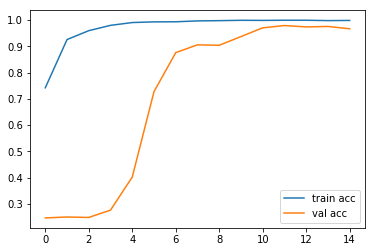

In [34]:
plt.plot(hist5['accuracy'], label='train acc')
plt.plot(hist5['val_accuracy'], label='val acc')
plt.legend()
plt.show()

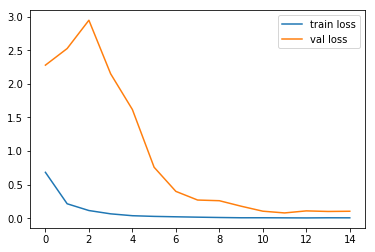

In [35]:
plt.plot(hist5['loss'], label='train loss')
plt.plot(hist5['val_loss'], label='val loss')
plt.legend()
plt.show()

In [36]:
pred = model5.predict(test_img)
pred = np.argmax(pred,axis=1)
print(pred)
print(test_y)

[0 2 0 ... 3 3 3]
[0 0 0 ... 3 3 3]


In [37]:
print(classification_report(test_y,pred))

              precision    recall  f1-score   support

           0       1.00      0.97      0.99       300
           1       1.00      1.00      1.00       405
           2       0.91      0.99      0.95       306
           3       1.00      0.93      0.96       300

    accuracy                           0.97      1311
   macro avg       0.98      0.97      0.97      1311
weighted avg       0.98      0.97      0.98      1311



# Results Comparision

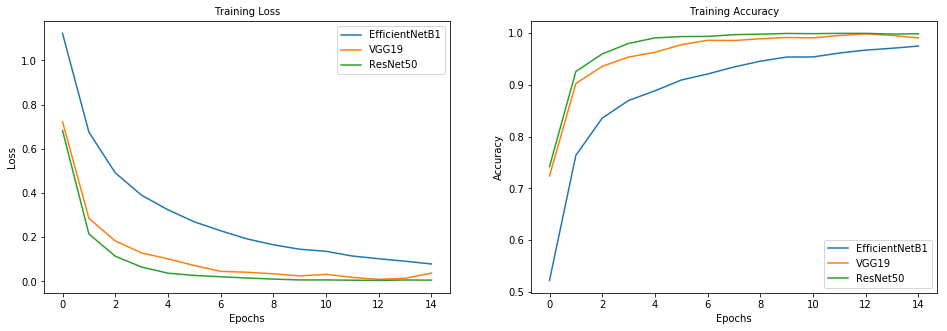

In [76]:
fig,ax=plt.subplots(1,2,figsize=(16,5))
ax[0].plot(hist3["loss"],label='EfficientNetB1')
ax[0].plot(hist4["loss"],label='VGG19')
ax[0].plot(hist5["loss"],label='ResNet50')
ax[0].set_title("Training Loss",fontsize=10)
ax[0].legend()
ax.flat[0].set(xlabel="Epochs",ylabel="Loss")

ax[1].plot(hist3["accuracy"],label='EfficientNetB1')
ax[1].plot(hist4["accuracy"],label='VGG19')
ax[1].plot(hist5["accuracy"],label='ResNet50')
ax[1].legend()
ax[1].set_title("Training Accuracy",fontsize=10)
ax.flat[1].set(xlabel="Epochs",ylabel="Accuracy")

plt.show()



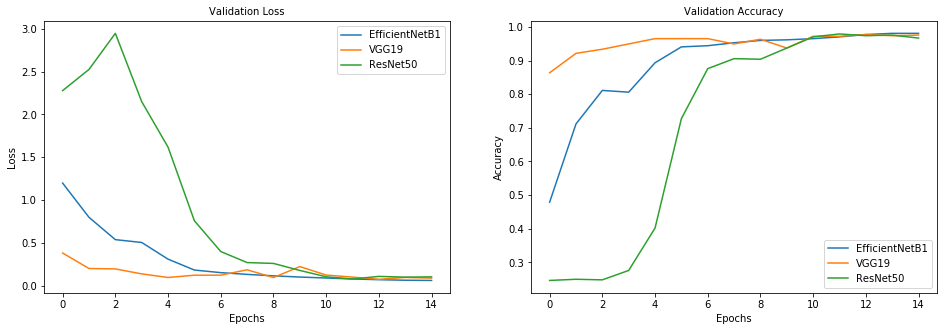

In [77]:
fig,ax=plt.subplots(1,2,figsize=(16,5))
plt.xlabel("Epochs")
plt.ylabel("Accuracy")
ax[0].plot(hist3["val_loss"],label='EfficientNetB1')
ax[0].plot(hist4["val_loss"],label='VGG19')
ax[0].plot(hist5["val_loss"],label='ResNet50')
ax[0].set_title("Validation Loss",fontsize=10)
ax[0].legend()
ax.flat[0].set(xlabel="Epochs",ylabel="Loss")

ax[1].plot(hist3["val_accuracy"],label='EfficientNetB1')
ax[1].plot(hist4["val_accuracy"],label='VGG19')
ax[1].plot(hist5["val_accuracy"],label='ResNet50')
ax[1].legend()
ax[1].set_title("Validation Accuracy",fontsize=10)
ax.flat[1].set(xlabel="Epochs",ylabel="Accuracy")
plt.xlabel("Epochs")
plt.ylabel("Accuracy")

plt.show()